In [13]:
import os # ADDED THIS LINE
os.environ['JAX_PLATFORMS'] = 'cpu' # ADDED THIS LINE

import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
import mujoco
from mujoco import mjx
from typing import Callable, Dict
from jax import Array

#  following line commented out due to error (but it worked befor.....)
from sysidmjx.core import generate_loss_train_functions, get_batch
from sysidmjx.assets.single_motor.dataloader.single_joint import data_load

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from jax import config

from datetime import datetime

current_time = datetime.now()

config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "high")



class PARAMS:
    SEED = jax.random.PRNGKey(42)
    EXPERIMENT_NAME = f"exo_optimization_try_{current_time.strftime('%Y%m%d_%H%M')}"

    class DATASET:
        PATH = "data/0.5Hz_RotPosition20260224110430(1).csv"
        DT = 0.00674  ## 1/0.006741 ≈ 148 Hz
        MAX_SAMPLES = 1000000  # Limit dataset size to avoid memory issues

    class SIM:
        PATH = "models/rotational_position.xml"
        INTEGRATOR = mujoco.mjtIntegrator.mjINT_EULER
        ITERATIONS = 5  # Match your XML

    class TRAIN:
        EPOCH_NUM = 1000  
        BATCH_SIZE = 128  # Smaller batches due to large dataset
        INITIAL_LEARNING_RATE = 0.01  # Moderate learning rate
        MIN_LEARNING_RATE = 1e-5
        PATIENCE = 200  # Stop if no improvement for 20 epochs
        SAVE_EVERY = 250  # Save checkpoint every 100 epochs
        TRAJECTORY_LENGTH = 50 # Use 50 timesteps (1s at 50Hz)

        # Cosine decay schedule
        @staticmethod
        def get_optimizer(num_epochs):
            schedule = optax.cosine_decay_schedule(
                init_value=PARAMS.TRAIN.INITIAL_LEARNING_RATE,
                decay_steps=num_epochs,
                alpha=PARAMS.TRAIN.MIN_LEARNING_RATE / PARAMS.TRAIN.INITIAL_LEARNING_RATE
            )
            return optax.adam(schedule)
        
        TX = None  # Will be set in training loop

# Joint names matching your actuators (10 joints)
JOINT_NAMES = [
    'rotational_position_joint',  # Joint 0
]

    # class MODEL:
    #     NUM_HIST_LAGS = 5

In [14]:
# Check the actual sampling rate
df = pd.read_csv(PARAMS.DATASET.PATH)
if 'time' in df.columns:
    time_diffs = np.diff(df['time'].values[:100])
    avg_dt = np.mean(time_diffs)
    actual_freq = 1.0 / avg_dt
    print(f"Detected CSV sampling rate: {actual_freq:.0f} Hz (dt={avg_dt:.6f}s)")
    
    # Adjust downsampling accordingly
    target_freq = 1000  # Hz
    downsample_factor = int(actual_freq / target_freq)
    print(f"Recommended downsample factor: {downsample_factor}")

Detected CSV sampling rate: 148 Hz (dt=0.006741s)
Recommended downsample factor: 0


# Load Exoskeleton Data

In [15]:
def load_exo_data(csv_path, max_samples=None, downsample_factor=20, trajectory_length=5):
    """Load exoskeleton data from CSV and prepare for simulation."""
    df = pd.read_csv(csv_path)
    
    n_samples_raw = len(df)
    n_joints = 1
    print(f"Total samples in CSV: {n_samples_raw}")
    
    # Load actuated joint data from CSV
    qpos_actuated = np.zeros((n_samples_raw, n_joints))
    qvel_actuated = np.zeros((n_samples_raw, n_joints))
    qctrl_raw = np.zeros((n_samples_raw, n_joints))
    
    
    qpos_actuated[:, 0] = df[f'encoder_pos'].values
    qvel_actuated[:, 0] = np.gradient(df['encoder_pos'].values, PARAMS.DATASET.DT)
    qctrl_raw[:, 0] = df[f'pos_setpoint'].values
    
    
    # Check for NaN or inf values
    if np.any(~np.isfinite(qpos_actuated)) or np.any(~np.isfinite(qvel_actuated)) or np.any(~np.isfinite(qctrl_raw)):
        print("WARNING: Non-finite values detected in raw data!")

    # Create rolling windows for trajectories
    num_windows = n_samples_raw - trajectory_length
    qpos_windows = np.array([qpos_actuated[i] for i in range(num_windows)])
    qvel_windows = np.array([qvel_actuated[i] for i in range(num_windows)])
    qctrl_windows = np.array([qctrl_raw[i : i + trajectory_length] for i in range(num_windows)])
    qpos_next_windows = np.array([qpos_actuated[i + 1 : i + 1 + trajectory_length] for i in range(num_windows)])
    qvel_next_windows = np.array([qvel_actuated[i + 1 : i + 1 + trajectory_length] for i in range(num_windows)])

    # Load model to get full DOF dimensions
    m = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)
    nq_full, nv_full = m.nq, m.nv
    
    # Create full qpos and qvel arrays
    qpos_full = np.tile(m.qpos0, (num_windows, 1))
    qvel_full = np.zeros((num_windows, nv_full))
    
    # Map actuated joint data to correct indices FOR rotational_position.xml
    actuated_qpos_idx = [0]
    actuated_qvel_idx = [0]


    for i in range(n_joints):
        qpos_full[:, actuated_qpos_idx[i]] = qpos_windows[:, i]
        qvel_full[:, actuated_qvel_idx[i]] = qvel_windows[:, i]

    dataset = {
        'qpos': jnp.array(qpos_full),
        'qvel': jnp.array(qvel_full),
        'qact': jnp.array(qctrl_windows),
        'qpos_next': jnp.array(qpos_next_windows),
        'qvel_next': jnp.array(qvel_next_windows)
    }
    
    return dataset, df

dataset, df = load_exo_data(
    PARAMS.DATASET.PATH, 
    max_samples=PARAMS.DATASET.MAX_SAMPLES, 
    downsample_factor=20,
    trajectory_length=PARAMS.TRAIN.TRAJECTORY_LENGTH
)

print(f"\nDataset loaded: {dataset['qpos'].shape[0]} samples (windows)")
print(f"  Full qpos shape: {dataset['qpos'].shape}")
print(f"  Full qvel shape: {dataset['qvel'].shape}")
print(f"  Control shape (qact): {dataset['qact'].shape} -> (samples, trajectory, joints)")
print(f"  Target shape (qpos_next): {dataset['qpos_next'].shape} -> (samples, trajectory, joints)")


Total samples in CSV: 5542

Dataset loaded: 5492 samples (windows)
  Full qpos shape: (5492, 1)
  Full qvel shape: (5492, 1)
  Control shape (qact): (5492, 50, 1) -> (samples, trajectory, joints)
  Target shape (qpos_next): (5492, 50, 1) -> (samples, trajectory, joints)


# Setup model

In [16]:
mj_model = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)
mj_model.opt.timestep = PARAMS.DATASET.DT
mj_model.opt.iterations = PARAMS.SIM.ITERATIONS
mj_model.opt.integrator = PARAMS.SIM.INTEGRATOR

# CRITICAL: Disable contacts/constraints to allow gradient computation
# MuJoCo's constraint solver uses while_loop which doesn't support reverse-mode autodiff
mj_model.opt.disableflags = mj_model.opt.disableflags | mujoco.mjtDisableBit.mjDSBL_CONSTRAINT

mj_data = mujoco.MjData(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
print(f"integrator:{mj_model.opt.integrator}")
print(f"timestep:{mj_model.opt.timestep}")
print(f"iterations:{mj_model.opt.iterations}")
print(f"constraints disabled: {bool(mj_model.opt.disableflags & mujoco.mjtDisableBit.mjDSBL_CONSTRAINT)}")

integrator:0
timestep:0.00674
iterations:5
constraints disabled: True


# Identify parameters and function they use

In [17]:
# Get number of joints and DOF structure
n_dof_total = mjx_model.nv
n_actuators = mjx_model.nu


# Indices of actuated joints in the full qpos/qvel arrays
ACTUATED_QPOS_IDX = jnp.array([0])
ACTUATED_QVEL_IDX = jnp.array([0])

# Use 5 timesteps (100ms at 50Hz) - balance between effect accumulation and computation
TRAJECTORY_LENGTH = 5

print(f"Number of actuated joints: {len(ACTUATED_QPOS_IDX)}")
print(f"Number of actuators in model: {n_actuators}")
print(f"Total qpos DOF: {mjx_model.nq}, Total qvel DOF: {n_dof_total}")
print(f"Actuated qpos indices: {ACTUATED_QPOS_IDX}")
print(f"Trajectory length: {TRAJECTORY_LENGTH} steps ({TRAJECTORY_LENGTH * PARAMS.DATASET.DT * 1000:.0f} ms)")

# Generate random keys for initialization
keys = jax.random.split(PARAMS.SEED, num=3)

# Define initial parameters for the model (set to zeros initially)
zero_params = {
    "armature": jnp.array([0.001]),
    "damping": jnp.array([0.001]),
}

# Define initial parameters - based on your XML defaults
init_params = {
    "armature": jnp.array([0.000024], dtype=jnp.float32),
    "damping": jnp.array([0.1], dtype=jnp.float32),
}


@jax.jit
def change_model(params: Dict, old_model: mjx.Model):

    full_armature = old_model.dof_armature.at[ACTUATED_QVEL_IDX].set(jnp.abs(params["armature"]))

    full_damping = old_model.dof_damping.at[ACTUATED_QVEL_IDX].set(jnp.abs(params["damping"]))
    # full_frictionloss = old_model.dof_frictionloss.at[ACTUATED_QVEL_IDX].set(jnp.abs(params["frictionloss"]))

    changed_model = old_model.replace(
        dof_armature=full_armature,
        dof_damping=full_damping,
        # dof_frictionloss=full_frictionloss,
    )

    return changed_model


@jax.jit
def make_action(params:Dict, data:mjx.Data, ctrl:Array):
    """Direct torque passthrough."""
    return ctrl


# Custom loss function that only compares actuated joint positions
@jax.jit
def predict_next_actuated(params, qpos0_full, qvel0_full, ctrl_vec):
    """Predict trajectory and extract only actuated joint positions."""
    sim_model = change_model(params, mjx_model)
    
    def body(carry, ctrl_t):
        qpos, qvel = carry
        # Reconstruct data with current state
        data = mjx_data.replace(qpos=qpos, qvel=qvel)
        # Apply control and step simulation
        u = make_action(params, data, ctrl_t)
        data = data.replace(ctrl=u)
        data = mjx.step(sim_model, data)
        
        # Extract actuated joint positions and velocity for output
        qpos_actuated = data.qpos[ACTUATED_QPOS_IDX]
        qvel_actuated = data.qvel[ACTUATED_QVEL_IDX]
        
        # Return only qpos and qvel to avoid dtype issues with contact arrays
        return (data.qpos, data.qvel), (qpos_actuated, qvel_actuated)
    
    # Initialize with qpos and qvel only
    carry0 = (qpos0_full, qvel0_full)
    _, (qpos_hist, qvel_hist) = jax.lax.scan(body, carry0, ctrl_vec)
    return qpos_hist, qvel_hist # (T, n_joints), (T, n_joints)


@jax.jit
def single_loss_actuated(params, qpos0_full, qvel0_full, ctrl_vec, qpos_des_actuated, qvel_des_actuated):
    """Loss comparing only actuated joint positions over multi-step trajectory."""
    # Use trajectory to accumulate damping/friction effects
    ctrl_trajectory = ctrl_vec[:TRAJECTORY_LENGTH]
    qpos_pred, qvel_pred = predict_next_actuated(params, qpos0_full, qvel0_full, ctrl_trajectory) 
    

    qpos_target = qpos_des_actuated[:TRAJECTORY_LENGTH]
    qvel_target = qvel_des_actuated[:TRAJECTORY_LENGTH]

    pos_loss = jnp.mean(jnp.square(qpos_pred - qpos_target))
    vel_loss = jnp.mean(jnp.square(qvel_pred - qvel_target))
    return pos_loss + 0.1 * vel_loss


loss_batch = jax.jit(jax.vmap(single_loss_actuated, in_axes=(None, 0, 0, 0, 0, 0)))

# @jax.jit
# def total_loss(params, qpos, qvel, ctrl_vec, qpos_des):
#     return jnp.mean(loss_batch(params, qpos, qvel, ctrl_vec, qpos_des))
# @jax.jit
# def total_loss(params, qpos, qvel, ctrl_vec, qpos_des):
#     base_loss = jnp.mean(loss_batch(params, qpos, qvel, ctrl_vec, qpos_des))
#     reg_term = 0.01 * jnp.sum(jnp.square(params["frictionloss"]))  # L2 regularization
#     return base_loss + reg_term

@jax.jit
def total_loss(params, qpos, qvel, ctrl_vec, qpos_des, qvel_des):
    base_loss = jnp.mean(loss_batch(params, qpos, qvel, ctrl_vec, qpos_des, qvel_des))
    # reg_term = 0.01 * jnp.sum(jnp.square(params["frictionloss"]))  # L2 regularization
    
    # Soft constraints to keep parameters in realistic range
    penalty = 1.0
    
    # Penalize if frictionloss goes below min or above max
    # min_friction = 0.1
    # max_friction = 100.0
    # penalty += jnp.sum(jnp.maximum(0, min_friction - params["frictionloss"])**2)
    # penalty += jnp.sum(jnp.maximum(0, params["frictionloss"] - max_friction)**2)

    min_damping = 0.0000001
    max_damping = 10
    penalty += jnp.sum(jnp.maximum(0, min_damping - params["damping"])**2)
    penalty += jnp.sum(jnp.maximum(0, params["damping"] - max_damping)**2)

    min_armature = 0.0001
    max_armature = 10
    penalty += jnp.sum(jnp.maximum(0, min_armature - params["armature"])**2)
    penalty += jnp.sum(jnp.maximum(0, params["armature"] - max_armature)**2)
    
    return base_loss + 0.1 * penalty 

value_and_grad = jax.jit(jax.value_and_grad(total_loss, argnums=0))


@jax.jit
def train_step(model_state, qpos, qvel, ctrl_vec, qpos_des, qvel_des):
    loss_val, grads = value_and_grad(model_state.params, qpos, qvel, ctrl_vec, qpos_des, qvel_des)

    new_state = model_state.apply_gradients(grads=grads)
    return new_state, grads

Number of actuated joints: 1
Number of actuators in model: 1
Total qpos DOF: 1, Total qvel DOF: 1
Actuated qpos indices: [0]
Trajectory length: 5 steps (34 ms)


# Training loop

In [18]:
import joblib
import time

PARAMS.TRAIN.TX = PARAMS.TRAIN.get_optimizer(PARAMS.TRAIN.EPOCH_NUM)

state = train_state.TrainState.create(
    apply_fn=None,
    params=init_params,
    tx=PARAMS.TRAIN.TX,
)

loss_hist = []
params_hist = []
indxs = jax.numpy.array(range(dataset["qpos"].shape[0]))

# Early stopping variables
best_loss = float('inf')
patience_counter = 0
best_params = None

# Create checkpoint directory
checkpoint_dir = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"=== STARTING TRAINING ===")
print(f"Dataset size: {dataset['qpos'].shape[0]} samples")
print(f"Batch size: {PARAMS.TRAIN.BATCH_SIZE}")
print(f"Max epochs: {PARAMS.TRAIN.EPOCH_NUM}")
print(f"Early stopping patience: {PARAMS.TRAIN.PATIENCE}")
print(f"Checkpoints saved to: {checkpoint_dir}\n")

start_time = time.time()

for epoch in range(PARAMS.TRAIN.EPOCH_NUM):
    # VALIDATE
    loss = total_loss(
        state.params,
        qpos=dataset["qpos"],
        qvel=dataset["qvel"],
        ctrl_vec=dataset["qact"],
        qpos_des=dataset["qpos_next"],
        qvel_des=dataset["qvel_next"],
    )
    loss_hist.append(loss)
    params_hist.append(state.params)
    
    # Early stopping check
    if loss < best_loss:
        best_loss = loss
        best_params = state.params
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print diagnostics every 5 epochs
    if epoch % 5 == 0:
        elapsed = time.time() - start_time
        print(f"\nEpoch {epoch}/{PARAMS.TRAIN.EPOCH_NUM}, Loss: {loss:.6f}, Best: {best_loss:.6f}, Patience: {patience_counter}/{PARAMS.TRAIN.PATIENCE}")
        print(f"  Elapsed time: {elapsed/60:.1f} min, Est. total: {elapsed/60 * PARAMS.TRAIN.EPOCH_NUM / max(epoch, 1):.1f} min")
        if epoch > 0:
            for param_name in ['armature', 'damping']:
                grad_norm = jnp.sqrt(jnp.sum(grads[param_name]**2))
                param_range = [jnp.min(state.params[param_name]), jnp.max(state.params[param_name])]
                print(f"  {param_name}: grad_norm={grad_norm:.6f}, range=[{param_range[0]:.3f}, {param_range[1]:.3f}]")
    
    # Save checkpoint periodically
    if epoch % PARAMS.TRAIN.SAVE_EVERY == 0 and epoch > 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.joblib")
        joblib.dump({
            'epoch': epoch,
            'params': state.params,
            'loss_hist': loss_hist,
            'best_params': best_params,
            'best_loss': best_loss
        }, checkpoint_path)
        print(f"  💾 Checkpoint saved: {checkpoint_path}")
    
    # Early stopping
    if patience_counter >= PARAMS.TRAIN.PATIENCE:
        print(f"\n⚠️ Early stopping triggered at epoch {epoch}")
        print(f"No improvement for {PARAMS.TRAIN.PATIENCE} epochs")
        break
    
    # TRAIN
    batch, indxs = get_batch(dataset, PARAMS.SEED, indxs, PARAMS.TRAIN.BATCH_SIZE)
    state, grads = train_step(
        state,
        qpos=batch["qpos"],
        qvel=batch["qvel"],
        ctrl_vec=batch["qact"],
        qpos_des=batch["qpos_next"],
        qvel_des=batch["qvel_next"],
    )

# Save final results
final_path = os.path.join(checkpoint_dir, "final_results.joblib")
joblib.dump({
    'final_params': state.params,
    'best_params': best_params,
    'loss_hist': loss_hist,
    'params_hist': params_hist,
    'best_loss': best_loss,
    'epochs_trained': len(loss_hist)
}, final_path)

total_time = time.time() - start_time
print(f"\n=== TRAINING COMPLETE ===")
print(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"Epochs trained: {len(loss_hist)}")
print(f"Final loss: {loss_hist[-1]:.6f}")
print(f"Best loss: {best_loss:.6f}")
print(f"Loss improvement: {(loss_hist[0] - best_loss) / loss_hist[0] * 100:.1f}%")
print(f"Final results saved to: {final_path}")

# Use best parameters
state = state.replace(params=best_params)

=== STARTING TRAINING ===
Dataset size: 5492 samples
Batch size: 128
Max epochs: 1000
Early stopping patience: 200
Checkpoints saved to: exo_experiments/exo_optimization_try_20260224_1448/checkpoints


Epoch 0/1000, Loss: 0.001268, Best: 0.001268, Patience: 0/200
  Elapsed time: 0.1 min, Est. total: 79.2 min
  Armature (fixed): 0.000024

Epoch 5/1000, Loss: 0.001223, Best: 0.001223, Patience: 0/200
  Elapsed time: 0.3 min, Est. total: 59.3 min
  Armature (fixed): 0.000024
  damping: grad_norm=0.000921, range=[0.149715, 0.149715]

Epoch 10/1000, Loss: 0.001180, Best: 0.001180, Patience: 0/200
  Elapsed time: 0.3 min, Est. total: 30.6 min
  Armature (fixed): 0.000024
  damping: grad_norm=0.000758, range=[0.198609, 0.198609]

Epoch 15/1000, Loss: 0.001140, Best: 0.001140, Patience: 0/200
  Elapsed time: 0.3 min, Est. total: 21.0 min
  Armature (fixed): 0.000024
  damping: grad_norm=0.000928, range=[0.247365, 0.247365]

Epoch 20/1000, Loss: 0.001101, Best: 0.001101, Patience: 0/200
  Elaps

In [19]:
# # Test gradient computation for all parameters
# print("Testing gradient computation...")
# test_batch_qpos = dataset['qpos'][:5]
# test_batch_qvel = dataset['qvel'][:5]
# test_batch_ctrl = dataset['qact'][:5]
# test_batch_target = dataset['qpos_next'][:5]
# test_batch_target = dataset['qpvel_next'][:5]

# # Compute loss and gradients
# test_loss, test_grads = value_and_grad(init_params, test_batch_qpos, test_batch_qvel, test_batch_ctrl, test_batch_target)
# print(f"\nTest loss: {test_loss:.6f}")

# print(f"\n=== GRADIENT STATISTICS ===")
# for param_name in ['armature', 'damping', 'frictionloss']:
#     print(f"\n{param_name.upper()}:")
#     print(f"  Mean: {jnp.mean(test_grads[param_name]):.10f}")
#     print(f"  Std: {jnp.std(test_grads[param_name]):.10f}")
#     print(f"  Range: [{jnp.min(test_grads[param_name]):.10f}, {jnp.max(test_grads[param_name]):.10f}]")
#     print(f"  Per-joint:")
#     for i, joint in enumerate(JOINT_NAMES):
#         print(f"    {joint}: {test_grads[param_name][i]:.10f}")

# # Test if parameters actually affect the simulation
# print(f"\n\n=== PARAMETER SENSITIVITY TEST ===")

# test_params_low = {
#     "armature": jnp.ones(n_joints) * 1.0,
#     "damping": jnp.ones(n_joints) * 0.01,
#     "frictionloss": jnp.ones(n_joints) * 0.01
# }
# test_params_high = {
#     "armature": jnp.ones(n_joints) * 10.0,
#     "damping": jnp.ones(n_joints) * 5.0,
#     "frictionloss": jnp.ones(n_joints) * 10.0
# }

# pred_low = predict_next_actuated(test_params_low, test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])
# pred_high_arm = predict_next_actuated({**test_params_low, "armature": test_params_high["armature"]}, 
#                                        test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])
# pred_high_damp = predict_next_actuated({**test_params_low, "damping": test_params_high["damping"]}, 
#                                         test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])
# pred_high_fric = predict_next_actuated({**test_params_low, "frictionloss": test_params_high["frictionloss"]}, 
#                                         test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])

# print(f"Armature effect (1.0 vs 10.0): {jnp.mean(jnp.abs(pred_low - pred_high_arm)):.10f}")
# print(f"Damping effect (0.01 vs 5.0): {jnp.mean(jnp.abs(pred_low - pred_high_damp)):.10f}")
# print(f"Frictionloss effect (0.01 vs 10.0): {jnp.mean(jnp.abs(pred_low - pred_high_fric)):.10f}")

# if jnp.mean(jnp.abs(pred_low - pred_high_damp)) < 1e-8:
#     print("\n⚠️ WARNING: Damping has almost no effect! This explains zero gradients.")
# if jnp.mean(jnp.abs(pred_low - pred_high_fric)) < 1e-8:
#     print("⚠️ WARNING: Frictionloss has almost no effect! This explains zero gradients.")


# Loss Analysis

In [20]:
baseline_loss = total_loss(
    zero_params,
    qpos=dataset["qpos"],
    qvel=dataset["qvel"],
    ctrl_vec=dataset["qact"],
    qpos_des=dataset["qpos_next"],
    qvel_des=dataset["qvel_next"],
)
adjusted_model_loss = np.array(loss_hist)
base_line = np.ones_like(adjusted_model_loss)

#### Armature plot



Fixed armature: 0.000024

Final optimized damping values:
  rotational_position_joint: 1.494459



Fixed armature: 0.000024

Final optimized damping values:
  rotational_position_joint: 1.494459


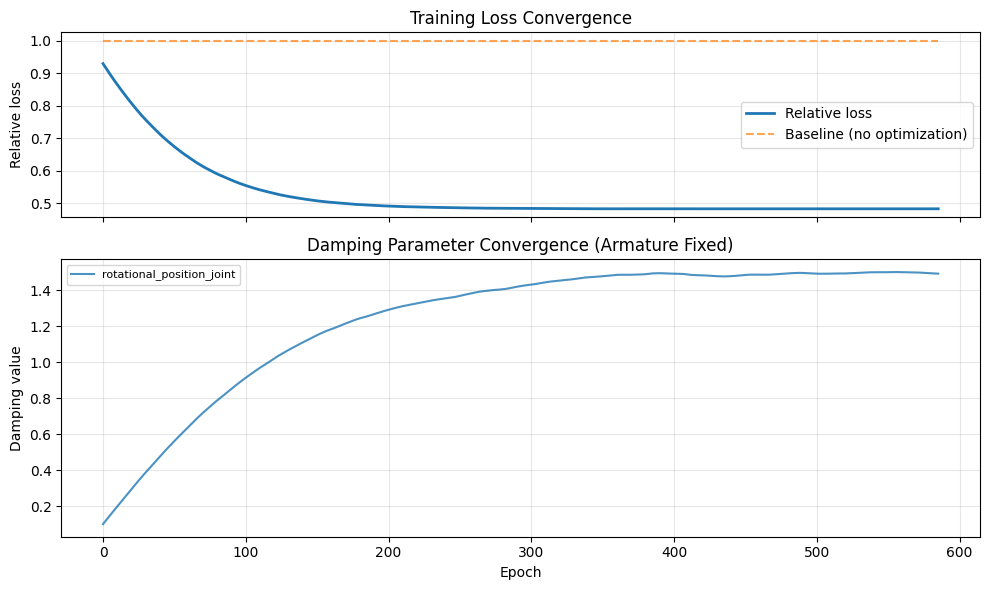

In [21]:
import matplotlib.pyplot as plt
import os, joblib

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [1, 1.5]}, sharex=True
)

# Plot loss convergence
ax1.plot(adjusted_model_loss / baseline_loss, label="Relative loss", linewidth=2)
ax1.plot(base_line, '--', label="Baseline (no optimization)", alpha=0.7)
ax1.set_title("Training Loss Convergence")
ax1.set_ylabel("Relative loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot armature parameter convergence for each joint
for i, joint in enumerate(JOINT_NAMES):
    values = [p["armature"][i] for p in params_hist]
    ax2.plot(values, label=joint, alpha=0.8)
ax2.set_title("Armature Parameter Convergence")
ax2.set_ylabel("Armature value")
ax2.set_xlabel("Epoch")
ax2.legend(fontsize=8, loc='best', ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save results
folder_path = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME)
os.makedirs(folder_path, exist_ok=True)
img_path = os.path.join(folder_path, "pictures")
os.makedirs(img_path, exist_ok=True)

joblib.dump(
    {
        "params": params_hist,
        "loss_hist": adjusted_model_loss,
        "baseline_loss": baseline_loss,
        "joint_names": JOINT_NAMES,
    },
    os.path.join(folder_path, "optimization_results.joblib"),
)

fig.savefig(
    os.path.join(img_path, "armature_optimization.png"),
    format="png",
    bbox_inches="tight",
    dpi=300
)

print(f"\nFinal optimized armature values:")
for i, joint in enumerate(JOINT_NAMES):
    print(f"  {joint}: {state.params['armature'][i]:.4f}")


### Damping Plot


Final optimized damping values:
  rotational_position_joint: 1.4945



Final optimized damping values:
  rotational_position_joint: 1.4945


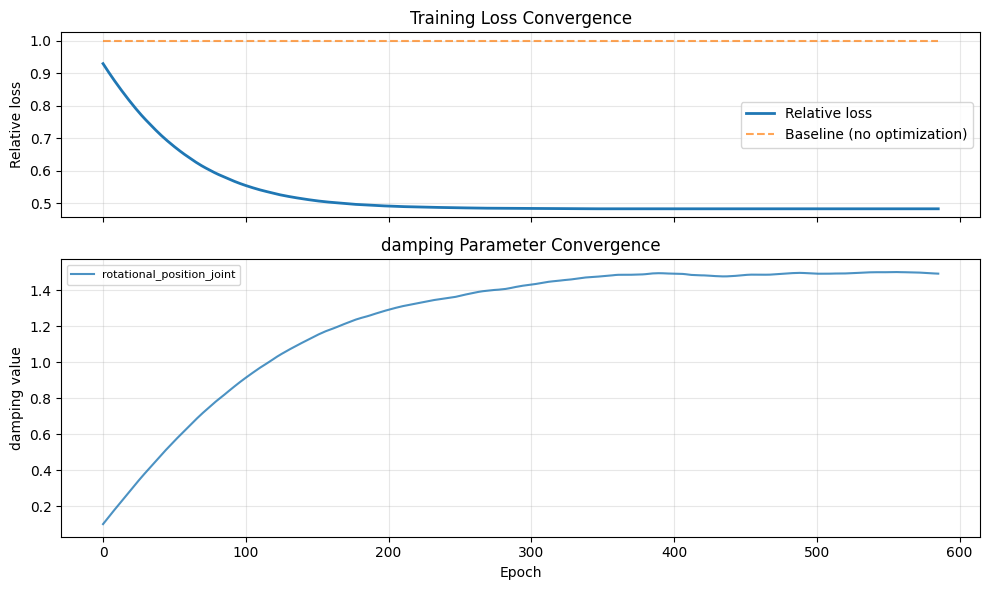

In [22]:
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [1, 1.5]}, sharex=True
)

# Plot loss convergence
ax1.plot(adjusted_model_loss / baseline_loss, label="Relative loss", linewidth=2)
ax1.plot(base_line, '--', label="Baseline (no optimization)", alpha=0.7)
ax1.set_title("Training Loss Convergence")
ax1.set_ylabel("Relative loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot damping parameter convergence for each joint
for i, joint in enumerate(JOINT_NAMES):
    values = [p["damping"][i] for p in params_hist]
    ax2.plot(values, label=joint, alpha=0.8)
ax2.set_title("damping Parameter Convergence")
ax2.set_ylabel("damping value")
ax2.set_xlabel("Epoch")
ax2.legend(fontsize=8, loc='best', ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save results
folder_path = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME)
os.makedirs(folder_path, exist_ok=True)
img_path = os.path.join(folder_path, "pictures")
os.makedirs(img_path, exist_ok=True)

joblib.dump(
    {
        "params": params_hist,
        "loss_hist": adjusted_model_loss,
        "baseline_loss": baseline_loss,
        "joint_names": JOINT_NAMES,
    },
    os.path.join(folder_path, "optimization_results.joblib"),
)

fig.savefig(
    os.path.join(img_path, "damping_optimization.png"),
    format="png",
    bbox_inches="tight",
    dpi=300
)

print(f"\nFinal optimized damping values:")
for i, joint in enumerate(JOINT_NAMES):
    print(f"  {joint}: {state.params['damping'][i]:.4f}")

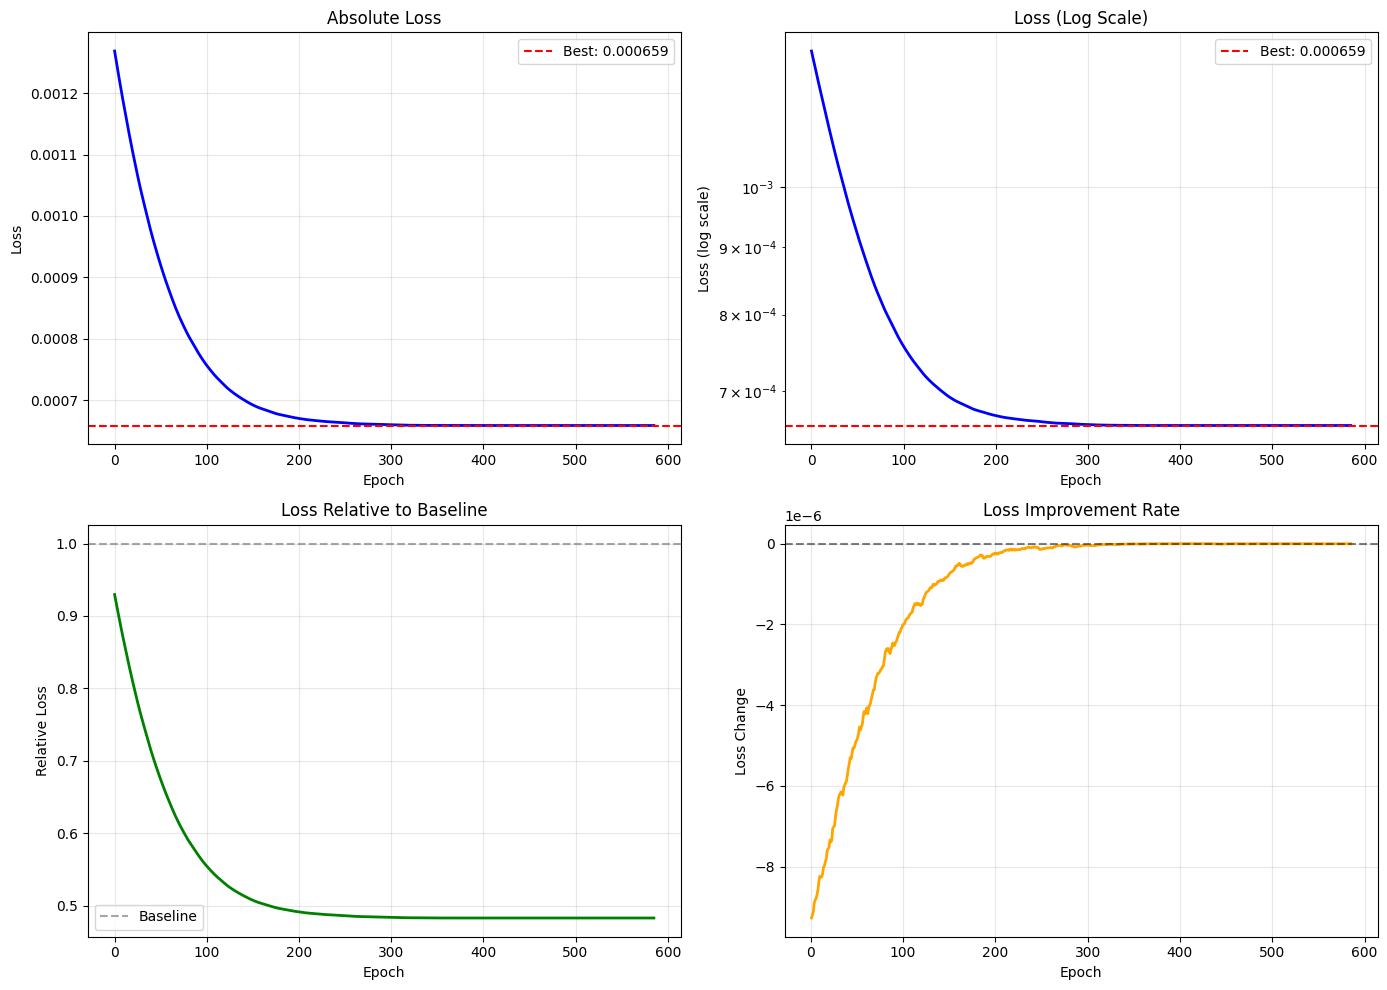


=== COST FUNCTION SUMMARY ===
Initial loss: 0.001268
Final loss: 0.000659
Best loss: 0.000659
Baseline loss: 0.001365
Improvement: 48.0%
Relative to baseline: 0.4830


In [23]:
# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = np.arange(len(loss_hist))

# 1. Absolute loss
axes[0, 0].plot(epochs, loss_hist, linewidth=2, color='blue')
axes[0, 0].axhline(y=best_loss, color='red', linestyle='--', label=f'Best: {best_loss:.6f}')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Absolute Loss")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Log scale loss
axes[0, 1].plot(epochs, loss_hist, linewidth=2, color='blue')
axes[0, 1].axhline(y=best_loss, color='red', linestyle='--', label=f'Best: {best_loss:.6f}')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss (log scale)")
axes[0, 1].set_title("Loss (Log Scale)")
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Relative to baseline
relative_loss = np.array(loss_hist) / baseline_loss
axes[1, 0].plot(epochs, relative_loss, linewidth=2, color='green')
axes[1, 0].axhline(y=1.0, color='gray', linestyle='--', label='Baseline', alpha=0.7)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Relative Loss")
axes[1, 0].set_title("Loss Relative to Baseline")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Loss improvement rate (derivative)
if len(loss_hist) > 1:
    loss_diff = np.diff(loss_hist)
    axes[1, 1].plot(epochs[1:], loss_diff, linewidth=2, color='orange')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Loss Change")
    axes[1, 1].set_title("Loss Improvement Rate")
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
folder_path = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME)
img_path = os.path.join(folder_path, "pictures")
os.makedirs(img_path, exist_ok=True)

fig.savefig(
    os.path.join(img_path, "cost_function_analysis.png"),
    format="png",
    bbox_inches="tight",
    dpi=300
)

plt.show()

# Print summary
print(f"\n=== COST FUNCTION SUMMARY ===")
print(f"Initial loss: {loss_hist[0]:.6f}")
print(f"Final loss: {loss_hist[-1]:.6f}")
print(f"Best loss: {best_loss:.6f}")
print(f"Baseline loss: {baseline_loss:.6f}")
print(f"Improvement: {(loss_hist[0] - best_loss) / loss_hist[0] * 100:.1f}%")
print(f"Relative to baseline: {best_loss / baseline_loss:.4f}")

In [24]:
# Add diagnostic to check if joints are actually moving
print("\n=== VELOCITY ANALYSIS ===")
for i, joint in enumerate(JOINT_NAMES):
    vel_values = dataset['qvel'][:, ACTUATED_QVEL_IDX[i]]
    print(f"{joint}:")
    print(f"  Mean |vel|: {jnp.mean(jnp.abs(vel_values)):.6f}")
    print(f"  Max |vel|:  {jnp.max(jnp.abs(vel_values)):.6f}")
    print(f"  % at rest:  {100 * jnp.mean(jnp.abs(vel_values) < 0.001):.1f}%")


=== VELOCITY ANALYSIS ===
rotational_position_joint:
  Mean |vel|: 0.482078
  Max |vel|:  1.558226
  % at rest:  4.1%
